## 기본 세팅

In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/T1_PJ/DATA/test/'

In [3]:
!pip install cvlib > /dev/null

In [4]:
!pip install imutils > /dev/null

## 영상 인식

[참고](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=dldudcks1779&logNo=222057069532)


In [5]:
##### 실행 #####
# 비디오를 저장하지 않을 경우
# webcam : sudo python3 real_time_object_detection.py
# 예) sudo python3 real_time_object_detection.py
# video : sudo python3 real_time_object_detection.py --input 비디오 경로
# 예) sudo python3 real_time_object_detection.py --input ./test_video/test_video_1.mp4
#
# 비디오를 저장할 경우
# webcam : sudo python3 real_time_object_detection.py --output 저장할 비디오 경로
# 예) sudo python3 real_time_object_detection.py --output ./result_video/result_video_1.avi
# video : sudo python3 real_time_object_detection.py --input 비디오 경로 --output 저장할 비디오 경로
# 예) sudo python3 real_time_object_detection.py --input ./test_video/test_video_1.mp4 --output ./result_video/result_video_1.avi

# 필요한 패키지 import
from imutils.video import FPS
import numpy as np # 파이썬 행렬 수식 및 수치 계산 처리 모듈
# import argparse # 명령행 파싱(인자를 입력 받고 파싱, 예외처리 등) 모듈
import easydict # argparse가 쥬피터에선 안됨
import imutils # 파이썬 OpenCV가 제공하는 기능 중 복잡하고 사용성이 떨어지는 부분을 보완(이미지 또는 비디오 스트림 파일 처리 등)
import time # 시간 처리 모듈
import cv2 # opencv 모듈
from google.colab.patches import cv2_imshow # cv2.imshow 대신 사용

In [41]:
opt = easydict.EasyDict({
        "input": path + '/IMG_5166.MOV', # input 경로
        "output": './a.avi', # output 경로
        "confidence": 0.5 # 최소 확률
})
# 입력받은 인자값을 args에 저장
args = vars(opt)

In [37]:
# 훈련된 클래스 labels 목록을 초기화
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

# 각 클래스에 대한 bounding box 색깔 random 지정
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# 모델(caffemodel 및 prototxt) load
print("[모델 loading...]")
net = cv2.dnn.readNetFromCaffe(path + "MobileNetSSD_deploy.prototxt.txt", path + "MobileNetSSD_deploy.caffemodel")

[모델 loading...]


In [42]:
# input 비디오 경로가 제공되지 않은 경우 webcam
if not args.get("input", False):
    print("[webcam 시작]")
    vs = cv2.VideoCapture(0)

# input 비디오 경로가 제공된 경우 video
else:
    print("[video 시작]")
    vs = cv2.VideoCapture(args["input"])

[video 시작]


In [43]:
# fps 정보 초기화
fps = FPS().start()

writer = None
(w, h) = (None, None)

# 비디오 스트림 프레임 반복
while True:
    # 프레임 읽기
    ret, frame = vs.read()
    
    # 읽은 프레임이 없는 경우 종료
    if args["input"] is not None and frame is None:
        break
    
    # 프레임 크기 지정
    frame = imutils.resize(frame, width=500)
    
    # 프레임 크기
    if w is None or h is None:
        (h, w) = frame.shape[:2]
    
    # blob 이미지 생성
    # 파라미터
    # 1) image : 사용할 이미지
    # 2) scalefactor : 이미지 크기 비율 지정
    # 3) size : Convolutional Neural Network에서 사용할 이미지 크기를 지정
    # 4) mean : Mean Subtraction 값을 RGB 색상 채널별로 지정해 주는 경험치 값(최적의 값)
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)),	0.007843, (300, 300), 127.5)
    
    # 객체 인식
    net.setInput(blob)
    detections = net.forward() # Caffe 모델이 처리한 결과값 : 4차원 배열

    # 객체 인식 수 만큼 반복
    for i in np.arange(0, detections.shape[2]):
        # 객체 확률 추출
        confidence = detections[0, 0, i, 2]
        
        # 객체 확률이 최소 확률보다 큰 경우
        if confidence > args["confidence"]:
            # 인식된 객체 index
            idx = int(detections[0, 0, i, 1])

            # bounding box 위치 계산
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            
            # bounding box 출력
            cv2.rectangle(frame, (startX, startY), (endX, endY), COLORS[idx], 2)
            
            # 객체 인식된 클래스 label 및 확률
            label = "{} : {:.2f}%".format(CLASSES[idx], confidence * 100)

            # label text 잘림 방지
            y = startY - 15 if startY - 15 > 15 else startY + 15

            # label text 출력
            cv2.putText(frame, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)
    
    # 프레임 출력
    # cv2.imshow("Real-Time Object Detection", frame)
    cv2_imshow(frame)
    key = cv2.waitKey(1) & 0xFF
    
    # 'q' 키를 입력하면 종료
    if key == ord("q"):
        break
    
    # fps 정보 업데이트
    fps.update()

    # output video 설정
    if args["output"] != "" and writer is None:
        fourcc = cv2.VideoWriter_fourcc(*'DIVX')
        writer = cv2.VideoWriter(args["output"], fourcc, 25, (frame.shape[1], frame.shape[0]), True)

    # 비디오 저장
    if writer is not None:
        writer.write(frame)

# fps 정지 및 정보 출력
fps.stop()
print("[재생 시간 : {:.2f}초]".format(fps.elapsed()))
print("[FPS : {:.2f}]".format(fps.fps()))

# 종료
vs.release()
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from IPython.display import HTML
from base64 import b64encode

avi = open('a.avi','rb').read()

data_url = "data:video/avi;base64," + b64encode(avi).decode()
HTML(""" 
<video width=500 controls> 
  <source src="%s" type="video/avi"> 
</video> """ % data_url)

## 이미지로 인식

In [ ]:
##### 실행 #####
# 이미지를 저장하지 않을 경우
# sudo python3 object_detection_image.py --input 이미지 경로
# 예) sudo python3 object_detection_image.py --input ./test_image/test_image_1.jpg
#
# 이미지를 저장할 경우
# sudo python3 object_detection_image.py --input 이미지 경로 --output 저장할 이미지 경로
# 예) sudo python3 object_detection_image.py --input ./test_image/test_image_1.jpg --output ./result_image/result_image_1.jpg

# 필요한 패키지 import
import numpy as np # 파이썬 행렬 수식 및 수치 계산 처리 모듈
import cv2 # opencv 모듈
import easydict # argparse가 쥬피터에선 안됨

In [ ]:
# 실행을 할 때 인자값 추가
opt = easydict.EasyDict({
        "input": path + './pet6.jpg', # input 경로
        "output": './a.jpg', # output 경로
        "confidence": 0.5 # 최소 확률
})

args = vars(opt)

In [ ]:
# 훈련된 클래스 labels 목록을 초기화
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

# 각 클래스에 대한 bounding box 색깔 random 지정
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# 모델(caffemodel 및 prototxt) load
print("[모델 loading...]")
net = cv2.dnn.readNetFromCaffe(path + "MobileNetSSD_deploy.prototxt.txt", path + "MobileNetSSD_deploy.caffemodel")

[모델 loading...]


[객체 인식]
[aeroplane : 74.13%]


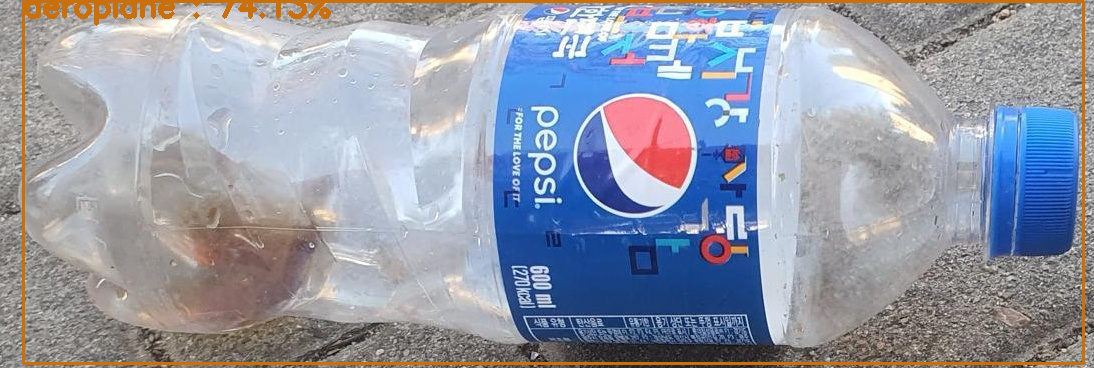

-1

In [ ]:
# input 이미지 읽기
image = cv2.imread(args["input"])

# 이미지 크기
(h, w) = image.shape[:2]

# blob 이미지 생성
# 파라미터
# 1) image : 사용할 이미지
# 2) scalefactor : 이미지 크기 비율 지정
# 3) size : Convolutional Neural Network에서 사용할 이미지 크기를 지정
# 4) mean : Mean Subtraction 값을 RGB 색상 채널별로 지정해 주는 경험치 값(최적의 값)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 0.007843, (300, 300), 127.5)

# 객체 인식
print("[객체 인식]")
net.setInput(blob)
detections = net.forward() # Caffe 모델이 처리한 결과값(4차원 배열)

# 객체 인식 수 만큼 반복
for i in np.arange(0, detections.shape[2]):
    # 객체 확률 추출
    confidence = detections[0, 0, i, 2]
    
    # 객체 확률이 최소 확률보다 큰 경우
    if confidence > args["confidence"]:
        # 인식된 객체 index
        idx = int(detections[0, 0, i, 1])

        # bounding box 위치 계산
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        
        # bounding box 출력
        cv2.rectangle(image, (startX, startY), (endX, endY), COLORS[idx], 2)
        
        # 객체 인식된 클래스 label 및 확률
        label = "{} : {:.2f}%".format(CLASSES[idx], confidence * 100)
        print("[{}]".format(label))
        
        # label text 잘림 방지
        y = startY - 15 if startY - 15 > 15 else startY + 15
        
        # label text 출력
        cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 1, COLORS[idx], 3)

# 이미지 저장
if args["output"] !=  None: # output 이미지 경로를 입력하였을 때(입력하지 않은 경우 저장되지 않음)
    cv2.imwrite(args["output"], image) # 파일로 저장, 포맷은 확장자에 따름

# 이미지 show
cv2_imshow(image)
cv2.waitKey(0)

In [ ]:
label_list

['bottle']

In [ ]:
# pet0 = [bottle : 75.64%]
# [bottle : 54.77%]
# [person : 84.73%]

# pet1 = 찌그러진 이미지 인식 못함

# pet2 = [diningtable : 82.34%]

# pet3 = [bottle : 99.40%]

# pet4 = [aeroplane : 97.62%]

# pet5 = [chair : 94.49%]

# pet6 = [aeroplane : 74.13%]